# Energy equipartition fitting example: discrete version

The following example shows how to measure the degree of energy equipartition using kinematic and mass information for stars within a globular cluster (GC). The methods presented here were used in [Aros & Vesperini (2023)](https://academic.oup.com/mnras/article/525/2/3136/7243400), to study the degree of energy equipartition on simulated GCs and the effects of dark remnants on the degree of energy equipartition. The fitting process follows the discrete approach descrived by [Watkins et al. (2022)](https://iopscience.iop.org/article/10.3847/1538-4357/ac77f7) and their likelihood function. For more detail check both referred articles. 

We can describe the degree of energy equipartition in a GC through the slope of the mass-dependent velocity dispersion. The goal is to measure the slope of the mass-dependent velocity dispersion given the proper motions and masses of stars within a region of the GC. Note that the degree of energy equipartition changes with radius, increasing towards the GC centre depending on how dinamically old the cluster is and the local relaxation time. Second note, as shown in Aros & Vesperini (2023), the presence of an intermediate-mass black hole might change significantly the degree of energy equipartition within the cluster centre.   

The two main models to describe the mass-dependent velocity dispersion are,

\begin{equation*}
\sigma(m) = \sigma_{0}\left(\frac{m}{m_{0}}\right)^{-\eta}\, \quad\quad (1)
\end{equation*}

where $\sigma_{0}$ is the velocity dispersion for stars with masses $m = m_{0}$, $m_{0}$ is a scale mass, that for the purpose of the methods used here we assume as $m_{0} = 1\,M_{\odot}$. Finally the log-slope of the mass-dependent velocity dispersion is given by $\eta$, where $\eta=0$ means no equipartition and $\eta=0.5$ means full equipartition. For more details check [Trenti et al. (2013)](https://academic.oup.com/mnras/article/435/4/3272/1031370).

The second approach to describe the degree of energy equipartition is given by, 

\begin{equation*}
\sigma(m) = 
    \begin{cases}
     \sigma_{0}\exp{(-0.5m/m_{\text{eq}})}  & \quad, m \leq m_{\text{eq}}\\
    \sigma_{\text{eq}}(m/m_{\text{eq}})^{-0.5}  & \quad, m > m_{\text{eq}},
    \end{cases} \quad\quad (2)
\end{equation*}

where $\sigma_{0}$ corresponds to the velocity dispersion of stars with masses at $m=0\,M_{\odot}$. $m_{\rm eq}$ is the _equipartition mass_, stars with masses larger than $m_{\rm eq}$ are considered to be in full equipartition (negative log-slope $\sim 0.5$) and stars with masses less than $m_{\rm eq}$ are still in partial equipartition. As the cluster becomes closer to equipartition the value of $m_{\rm eq}$ decreases. Finally $\sigma_{\rm eq}$ corresponds to the velocity dispersion at $m=m_{\rm eq}$ and is defined as $\sigma_{\text{eq}} = \sigma_{0}\exp{(-0.5)}$.  



As we describe in Aros & Vesperini (2023), instead of using directly the _equipartition mass_, we define 

\begin{equation*}
\mu = 1/m_{\rm eq}\, \quad\quad (3)
\end{equation*}

as the tracer of the degree of energy equipartition for equation (2). This allows for a continous sampling of the parameter space in the fitting process as well to describe the cases with an IMBH. Check Aros & Vesperini (2023) for more details. In practice a value of $\mu=0$ means no equipartition while a value of $\mu=10$ might be consistent with full equipartition (as it means a $m_{\rm eq}=0.1\,M_{\odot}$, and most of the stars in the cluster will be in the _full equipartition_ regime of equation (2)).



In the following we show an aplication to a mock data set for a simulated GC. The data corresponds to the same cluster as used as example for panel (a) of Figure 1 in Aros & Vesperini (2023). Slight differences one the estimated values corresponds to a different realization of the added observational errors for the simulation data. For further detail check the article. 

In [1]:
## Required packages and methods for the example

__Important!__

__The code uses the packages ```numpy``` and ```emcee``` for numerical methods and the Markov Chain Monte Carlo sampling used during the fitting process. ```emcee``` can be installed through ```pip```, check the main site of ```emcee``` for details on the installation and further documentation [https://emcee.readthedocs.io/en/stable/user/install/](https://emcee.readthedocs.io/en/stable/user/install/).__  

__This example also makes use of the packages ```astropy``` and ```corner``` for reading tables and making corner plots respectively. Documentation for ```astropy``` is available at [https://docs.astropy.org/en/stable/index.html](https://docs.astropy.org/en/stable/index.html), and for ```corner``` the documentation is available at [https://corner.readthedocs.io/en/latest/](https://corner.readthedocs.io/en/latest/).__

In [2]:
## Numerical methods
import numpy as np

In [3]:
## Plotting methods
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

## we use corner.py for plotting corner plots from the MCMC results
import corner

## Publication-like style for latex in matplotlib
plt.rcParams["font.family"] = "stix"
plt.rcParams["mathtext.fontset"] = "stix"

In [4]:
## For reading the "example_data.dat" file and keep the table headers 
from astropy.io import ascii

The main methods for estimating the degree of energy equipartition are included in the following python codes: 

(a) ```fit_kin_two``` has methods for estimating the one dimensional velocity dispersion from the kinematic data using a likelihood function, and also include a method for getting the mass-dependent velocity dispersion profile giving either mass bins or a number of bins to make equal number bins in mass. 

(b) ```fit_eta_two``` includes methods for estimating the degree of energy equipartition using equation (1), i.e. using the $\eta$ parameter for the log-slope of the mass dependent velocity dispersion.

(c) ```fit_mu_two``` includes methods for estimating the degree of energy equipartition using equation (2), with the reparameterization of $\mu=1/m_{\rm eq}$ for the log-slope of the mass dependent velocity dispersion.

All codes use ```emcee``` to sample the Markov chain Monte Carlo fitting approach. 

In [5]:
## Methods for the estimation of the degree of energy equipartition.

import EEQ_fits.fit_kin_two as fit_kin_two
import EEQ_fits.fit_eta_two as fit_eta_two
import EEQ_fits.fit_mu_two as fit_mu_two

## DATA

The mock data includes stars of a simulated globular cluster at 12 Gyr, from the MOCCA Survey I ([Askar et al. (2017)](https://academic.oup.com/mnrasl/article/464/1/L36/2890987)). The stars are all within $10\%$ of the 2D half-light radius, have masses between $0.2\,M_{\odot}$ and the mass of the main sequence turn-off ($\sim 0.81\,M_{\odot}$), and are limited to single stars wihin the main sequence. The velocities of all stars in the sample have an observational error given their magnitude, mimicking the observed HST errors for NGC 6752 from the HACKS catalogue ( [https://archive.stsci.edu/hlsp/hacks](https://archive.stsci.edu/hlsp/hacks) see also [Libralato et al. (2022)](https://iopscience.iop.org/article/10.3847/1538-4357/ac7727)). A more complete detail on the sample selection and observable mock date is available in Aros & Vesperini (2023).

In [6]:
## We used the ascii module in astropy.io to read the mock data for this example.
## alternatively you can use any other reader, keep in mind the column headers 
## and update the example accordingly.
##
##  col1: 'R'      (2D distance from the cluster centre in pc)
##  col2: 'vR'     (Radial proper motion in projected in the sky in km/s)
##  col3: 'err_vR' (Error in the radial proper motion)
##  col4: 'vT'     (Tangential proper motion in projected in the sky in km/s)
##  col5: 'err_vT' (Error in the tangential proper motion)
##  col6: 'V-B'    (V-B color in manitudes)
##  col7: 'V'      (Absolute V magnitude)
##  col8: 'Mass'   (Stellar mass in Msun)

DATA = ascii.read('example_data.dat')

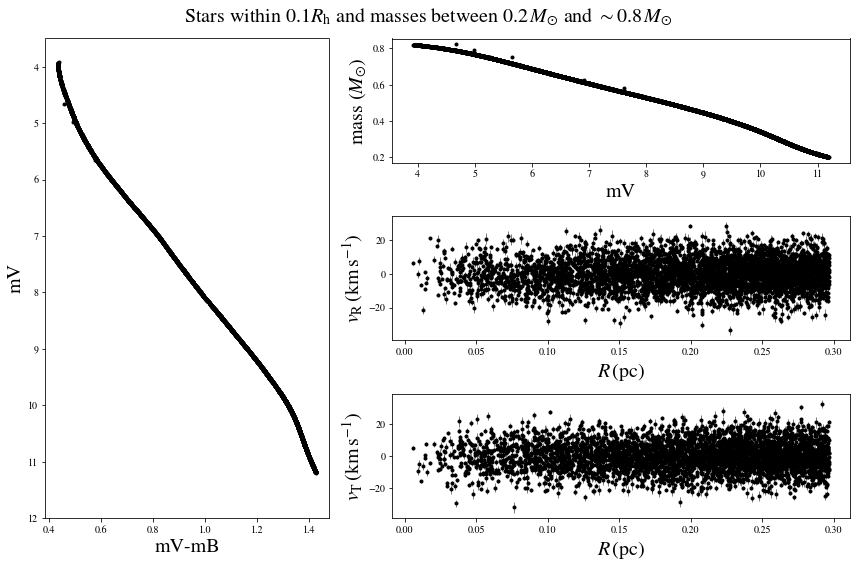

In [7]:
fig = plt.figure(figsize=(12,8))

gsc = fig.add_gridspec(3,5) 

ax_cmd  = fig.add_subplot(gsc[:,:2])
ax_mass = fig.add_subplot(gsc[0,2:])
ax_kin  = [fig.add_subplot(gsc[1,2:]),fig.add_subplot(gsc[2,2:])]

## CMD
ax_cmd.plot(DATA['V-B'],DATA['V'],'.k')
ax_cmd.set_ylim([12,3.5])
ax_cmd.set_xlabel(r'mV-mB',fontsize=20)
ax_cmd.set_ylabel(r'mV',fontsize=20)

## Mass
ax_mass.plot(DATA['V'],DATA['Mass'],'.k')
ax_mass.set_xlabel(r'mV',fontsize=20)
ax_mass.set_ylabel(r'mass ($M_{\odot}$)',fontsize=20)

## Kin
ax_kin[0].errorbar(DATA['R'],DATA['vR'],DATA['err_vR'],fmt='.k',lw=0.5)
ax_kin[0].set_ylabel(r'$v_{\rm R}\,(\rm km\,\rm s^{-1})$',fontsize=20)
ax_kin[0].set_xlabel(r'$R\,(\rm pc)$',fontsize=20)

ax_kin[1].errorbar(DATA['R'],DATA['vT'],DATA['err_vT'],fmt='.k',lw=0.5)
ax_kin[1].set_ylabel(r'$v_{\rm T}\,(\rm km\,\rm s^{-1})$',fontsize=20)
ax_kin[1].set_xlabel(r'$R\,(\rm pc)$',fontsize=20)


###########################
fig.suptitle(r'Stars within $0.1R_{\rm h}$ and masses between $0.2\,M_{\odot}$ and $\sim 0.8\,M_{\odot}$',fontsize=20)
fig.tight_layout()
plt.show()


## Sigma-Mass

For estimating the one dimensional velocity dispersion given the observed proper motions and their error, the ```fit_kin_two``` code uses the following likelihood function:

\begin{equation*}
L(v_{\text{pmR}},v_{\text{pmT}}\mid \sigma_{\rm 2D}) = \prod_{i}^{N}(2\pi(\sigma_{\rm 2D}^2+\delta_{\text{pmR},i}^2))^{-1/2}\times(2\pi(\sigma_{\rm 2D}^2+\delta_{\text{pmT},i}^2))^{-1/2}\times\exp\left(-\frac{1}{2}{\frac{v_{\text{pmR},i}^2}{\sigma_{\rm 2D}^2+\delta_{\text{pmR},i}^2}-\frac{1}{2}\frac{v_{\text{pmT},i}^2}{\sigma_{\rm 2D}^2+\delta_{\text{pmT},i}^2}}\right)\,,\quad\quad (4)    
\end{equation*}

where $\sigma_{\rm 2D}$ is the one dimensional velocity dispersion. We assume that the one dimensional mean velocity is zero. For estimating the mass-dependent velocity dispersion the method ```get_prf_tot2D_fixbins``` takes the kinematic data, the observed magnitude and mass of each star as well as an array with mass bins to construct the mass-dependent velocity dispersion profile. The method gives back an array with: 

In [35]:
# [0] median magnitude
# [1] median mass
# [2] sigma_2D$
# [3] err_sigma_2D (16th percentile)
# [4] err_sigma_2D (84th percentile)

```fit_kin_two``` also includes the method ```get_prf_tot2D_equalnumber``` wich receives a number of bins rather than an array with the bin edges, and make the bins so they have the same number of stars sorted by mass.

In [8]:
## example with fixed bins

mass_bins = np.linspace(np.amin(DATA['Mass']),np.amax(DATA['Mass']),8)

In [9]:
sigma_prf = fit_kin_two.get_prf_tot2D_fixbins(DATA['vR'],DATA['err_vR'],DATA['vT'],DATA['err_vT'],
                                              DATA['V'],DATA['Mass'],mass_bins,n_walkers=100,progress=True)

100%|██████████| 1000/1000 [01:28<00:00, 11.36it/s]


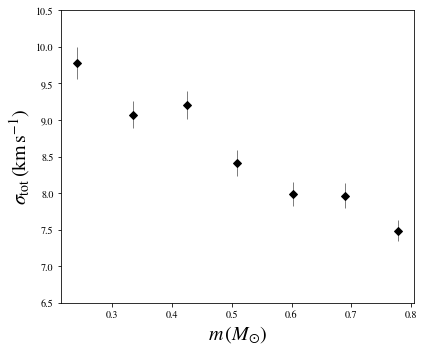

In [10]:
fig,axs = plt.subplots(1,1,figsize=(6,5))


axs.errorbar(sigma_prf[1],sigma_prf[2],yerr=[sigma_prf[3],sigma_prf[4]], fmt='Dk',ms=5,lw=0.5)
    
###################
axs.set_ylim([6.5,10.5])

axs.set_ylabel(r'$\sigma_{\rm tot}\,(\rm km\,\rm s^{-1})$',fontsize=20)
axs.set_xlabel(r'$m\,(M_{\odot})$',fontsize=20)

##################
fig.tight_layout()

plt.show()

## DISCRETE EQUIPARTITION FIT

To estimate the degree of energy equipartition both codes (```fit_eta_two``` and ```fit_mu_two```) follow the same likelihood function:

\begin{equation}
L(v_{\text{pmR}},v_{\text{pmT}},m\mid\Theta) = \prod_{i}^{N}(2\pi(\sigma(m_i\mid\Theta)^2+\delta_{\text{pmR},i}^2))^{-1/2}\times(2\pi(\sigma(m_i\mid\Theta)^2+\delta_{\text{pmT},i}^2))^{-1/2}\times\exp\left(-\frac{1}{2}{\frac{v_{\text{pmR},i}^2}{\sigma(m_i\mid\Theta)^2+\delta_{\text{pmR},i}^2}-\frac{1}{2}\frac{v_{\text{pmT},i}^2}{\sigma(m_i\mid\Theta)^2+\delta_{\text{pmT},i}^2}}\right)\,,  \quad\quad (5)  
\end{equation}

where $\sigma(m_i\mid\Theta)$ is the mass-dependent velocity dispersion following either equations (1) or (2). This likelihood was introduced by Watkins et al. (2022) and we used it on Aros & Vesperini (2023). 

Both codes ```fit_eta_two``` and ```fit_mu_two```, uses the same methods and arguments and give the same outputs with the differece of the model for the mass-dependent velocity dispersion ```model_eta()``` and ```model_mu()``` respectively.

In [11]:
## assume initial predition of sigma_0~8, mu=0 or nu=0 (no equipartition)
init_guess = np.array([6,0])

### (a) best-fit results

In both cases, the methods ```get_mu_fit()``` and ```get_eta_fit()```, receive as arguments the kinematic data, the masses of each star in the system and an initial guess for the parameters, and it returns an array with 6 elements:  

In [37]:
## get_mu_fit(vR,err_vR,vT,err_vT,,mass,init_guess) => [best_s0, s0_16th, s0_84th, best_mu, mu_16th, mu_84th]
## get_eta_fit(vR,err_vR,vT,err_vT,,mass,init_guess) => [best_s0, s0_16th, s0_84th, best_eta, eta_16th, eta_84th]

In [12]:
mu_fit = fit_mu_two.get_mu_fit(DATA['vR'],DATA['err_vR'],DATA['vT'],DATA['err_vT'],DATA['Mass'],init_guess,
                                 n_burn=800,n_walkers=20,n_steps=1000,progress=True)                                                             

100%|██████████| 1000/1000 [00:41<00:00, 24.35it/s]


In [13]:
eta_fit = fit_eta_two.get_eta_fit(DATA['vR'],DATA['err_vR'],DATA['vT'],DATA['err_vT'],DATA['Mass'],init_guess,
                                  n_burn=800,n_walkers=20,n_steps=1000,progress=True)                                                             

100%|██████████| 1000/1000 [00:37<00:00, 26.72it/s]


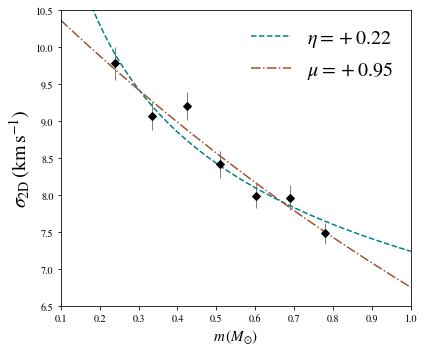

In [14]:
fig,axs = plt.subplots(1,1,figsize=(6,5))

colors = ['teal','sienna']

axs.errorbar(sigma_prf[1],sigma_prf[2],yerr=[sigma_prf[3],sigma_prf[4]], fmt='Dk',ms=5,lw=0.5)

## BEST FIT MODELS
models_mass = np.linspace(0.1,1.0,100)

axs.plot(models_mass,fit_eta_two.model_eta(models_mass,eta_fit[0],eta_fit[3]),'--',c=colors[0],label=r'$\eta=%+5.2lf$'%(eta_fit[3]))
axs.plot(models_mass,fit_mu_two.model_mu(models_mass,mu_fit[0],mu_fit[3]),'-.',c=colors[1],label=r'$\mu =%+5.2lf$'%(mu_fit[3]))

axs.legend(frameon=False,fontsize=20)

###################
axs.set_ylim([6.5,10.5])
axs.set_xlim([0.1,1.0])

axs.set_ylabel(r'$\sigma_{\rm 2D}\,(\rm km\,\rm s^{-1})$',fontsize=20)
axs.set_xlabel(r'$m\,(M_{\odot})$',fontsize=15)

##################
fig.tight_layout()

plt.show()

### (b) posterior distribution -- Full MCMC chains

The codes also include the in-between step to recover the full MCMC chains for the fitting allowing for the analysis of the posterior distribution of the fitted parameters. The methods ```fit_dis_mu``` and ```fit_dis_eta```, takes the kinematics and masses as well as an initial guess for the parameters and return two n-array with the samples (with a shape of [n_walkers,n_steps,n_dim]) and the logprobability (with shape [n_walkers,n_steps]).

Check the documentation for ```emcee``` for further details, here we show and example of how to extract the samples and logprobability (as tracer of the loglikelihood), build corner plots for the posterior distribution and a range of models to understand the effects of the posterior distribution in the models.


In [25]:
mu_chains = fit_mu_two.fit_dis_mu(DATA['vR'],DATA['err_vR'],DATA['vT'],DATA['err_vT'],DATA['Mass'],init_guess,
                                    n_walkers=20,n_steps=1000,progress=True)                                                             

100%|██████████| 1000/1000 [00:40<00:00, 24.58it/s]


In [16]:
eta_chains = fit_eta_two.fit_dis_eta(DATA['vR'],DATA['err_vR'],DATA['vT'],DATA['err_vT'],DATA['Mass'],init_guess,
                                     n_walkers=20,n_steps=1000,progress=True)                                                             

100%|██████████| 1000/1000 [00:38<00:00, 26.08it/s]


#### (b.1) chains visualization

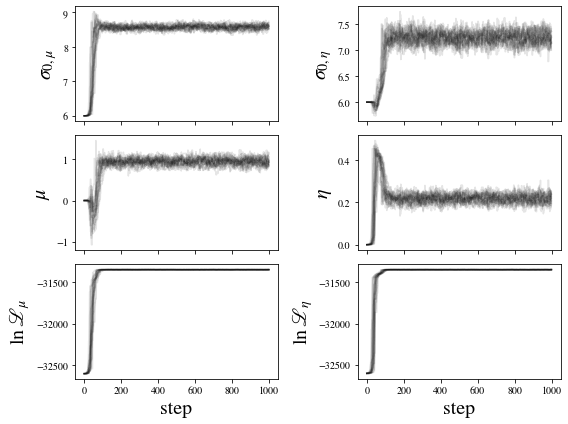

In [26]:
fig,axs = plt.subplots(3,2,figsize=(8,6),sharex=True)

## chain mu
for k in range(mu_chains[0].shape[0]):
    axs[0,0].plot(mu_chains[0][k,:,0],'-k',alpha=0.1)
    axs[1,0].plot(mu_chains[0][k,:,1],'-k',alpha=0.1)
    axs[2,0].plot(mu_chains[1][k,:],'-k',alpha=0.1)


## chain eta
for k in range(eta_chains[0].shape[0]):
    axs[0,1].plot(eta_chains[0][k,:,0],'-k',alpha=0.1)
    axs[1,1].plot(eta_chains[0][k,:,1],'-k',alpha=0.1)
    axs[2,1].plot(eta_chains[1][k,:],'-k',alpha=0.1)

axs[0,0].set_ylabel(r'$\sigma_{0,\mu}$',fontsize=20)
axs[1,0].set_ylabel(r'$\mu$',fontsize=20)
axs[2,0].set_ylabel(r'$\ln \mathscr{L}_{\mu}$',fontsize=20)
axs[2,0].set_xlabel(r'step',fontsize=20)


axs[0,1].set_ylabel(r'$\sigma_{0,\eta}$',fontsize=20)
axs[1,1].set_ylabel(r'$\eta$',fontsize=20)
axs[2,1].set_ylabel(r'$\ln \mathscr{L}_{\eta}$',fontsize=20)
axs[2,1].set_xlabel(r'step',fontsize=20)

#####################################
fig.tight_layout()
plt.show()



#### (b.2) burn out initial steps

In [27]:
## burn
n_burn = 800

mu_samples = mu_chains[0][:,n_burn:,:].reshape((-1,2))
mu_loglike = mu_chains[1][:,n_burn:].reshape((-1))

eta_samples = eta_chains[0][:,n_burn:,:].reshape((-1,2))
eta_loglike = eta_chains[1][:,n_burn:].reshape((-1))



#### (b.3) corner plots

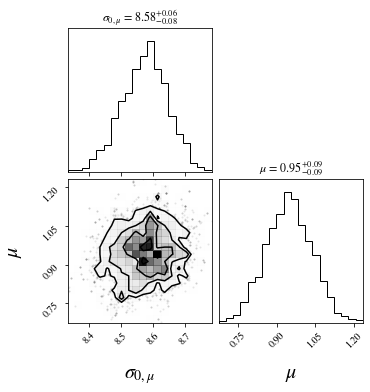

In [28]:
fig_corner_mu = corner.corner(mu_samples,labels=[r'$\sigma_{0,\mu}$',r'$\mu$'],show_titles=True,label_kwargs={"fontsize":20})

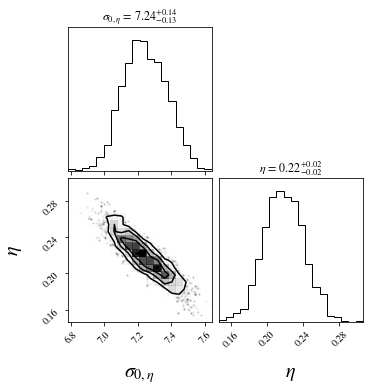

In [29]:
fig_corner_eta = corner.corner(eta_samples,labels=[r'$\sigma_{0,\eta}$',r'$\eta$'],show_titles=True,label_kwargs={"fontsize":20})

#### (b.4) models distributions

In [30]:
n_models = 1000

## set model i=0 as the maximum likelihood one
idx_choice_mu    = np.zeros(n_models+1).astype(int)
idx_choice_mu[0] = np.argmax(mu_loglike)
idx_choice_mu[1:]= np.random.choice(range(mu_samples.shape[0]),size=n_models,replace=False)


idx_choice_eta    = np.zeros(n_models+1).astype(int)
idx_choice_eta[0] = np.argmax(eta_loglike)
idx_choice_eta[1:]= np.random.choice(range(eta_samples.shape[0]),size=n_models,replace=False)


In [31]:
models_mu  = np.zeros((n_models+1,models_mass.size)) 
models_eta = np.zeros((n_models+1,models_mass.size))



for k in range(n_models+1):    
    models_eta[k] = fit_eta_two.model_eta(models_mass,*eta_samples[idx_choice_eta[k]])
    models_mu[k]  = fit_mu_two.model_mu(models_mass,*mu_samples[idx_choice_mu[k]])
    

#### (b.5) final figure including the 90% range of randomly selected models

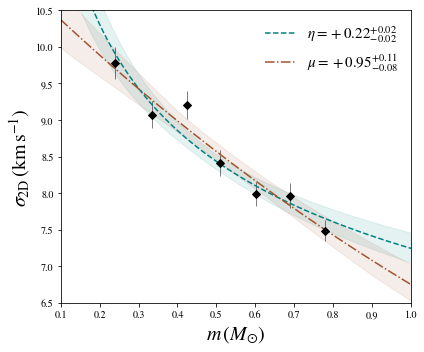

In [32]:
fig,axs = plt.subplots(1,1,figsize=(6,5))

colors = ['teal','sienna']

axs.errorbar(sigma_prf[1],sigma_prf[2],yerr=[sigma_prf[3],sigma_prf[4]], fmt='Dk',ms=5,lw=0.5)

## full mcmc models
axs.plot(models_mass,models_eta[0],'--',c=colors[0],label=r'$\eta=%+5.2lf_{-%5.2lf}^{+%5.2lf}$'%(eta_fit[3],eta_fit[4],eta_fit[5]))

## add 90% range: 5 to 95 percentiles 
axs.fill_between(models_mass,np.percentile(models_eta,5,axis=0),np.percentile(models_eta,95,axis=0),color=colors[0],alpha=0.1)


axs.plot(models_mass,models_mu[0],'-.',c=colors[1],label=r'$\mu =%+5.2lf_{-%5.2lf}^{+%5.2lf}$'%(mu_fit[3],mu_fit[4],mu_fit[5]))

## add 90% range: 5 to 95 percentiles 
axs.fill_between(models_mass,np.percentile(models_mu,5,axis=0),np.percentile(models_mu,95,axis=0),color=colors[1],alpha=0.1)

##
axs.legend(frameon=False,fontsize=15)


###################
axs.set_ylim([6.5,10.5])
axs.set_xlim([0.1,1.0])


axs.set_ylabel(r'$\sigma_{\rm 2D}\,(\rm km\,\rm s^{-1})$',fontsize=20)
axs.set_xlabel(r'$m\,(M_{\odot})$',fontsize=20)

##################
fig.tight_layout()

plt.show()

This figure is similar to the panel (a) of Figure 1 in Aros & Vesperini (2023), whith slight differences due to the random realization of the added observational errors. This and the best fit value quoted on the article are within the measured 1sigma range of the posterior distribution.